# 파이토치 MNIST 모델

## modules import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

<ipython-input-1-254f20b072c8>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## 전처리 설정
- `transform.Compose`

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))]) # PIL이미지를 텐서형태로

## 데이터 로드 및 데이터 확인

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True,
                                      transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True,
                                      transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 90355659.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28395615.05it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24372068.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 26831730.66it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2)

In [ ]:
image, label = next(iter(train_loader))

In [ ]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # 28 28 1
  plt.show()

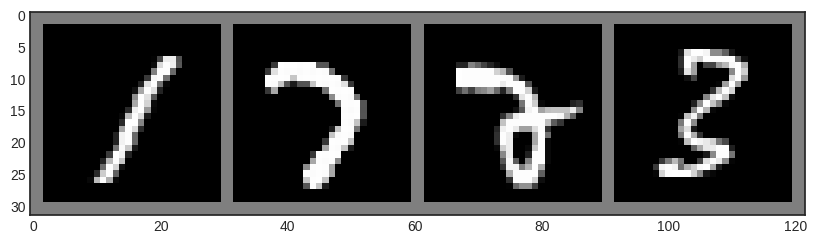

In [ ]:
dataiter = iter(train_loader)

images, labels = next(dataiter)

# 이미지 여러개 볼 수 있게 : torchvision.utils.make_grid
imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__() # init 호출

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))

    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s

    return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()`

In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [ ]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[0.0000, 0.0000, 0.0442, 0.0412, 0.0000, 0.0000, 0.0354, 0.0000, 0.1023,
         0.0000]], grad_fn=<ReluBackward0>)


## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [ ]:
total_batch = len(train_loader)
print(total_batch) # 32개 이미지로 이루어진 469개 집합이 각각 모델에 들어간다.

469


- 설명을 위해 `epochs=2`로 지정

In [ ]:
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    optimizer.zero_grad() # 매개변수 0으로 만들기

    outputs = net(inputs) # 포워드
    loss = criterion(outputs, labels) # 로스값 계산
    loss.backward() # 백워드 계산 하고
    optimizer.step() # 다음 스텝으로 넘겨주는 역할

    running_loss += loss.item()
    if i % 100 == 99:
      # 100번 돌렸을 때(32개 이미지 집합을 100번) 즉, 백 번 돌린 loss 평균
      print(f'Epoch: {epoch+1}, Iter: {i+1}, Loss:{running_loss/100}')
      running_loss = 0.0

Epoch: 1, Iter: 100, Loss:2.136798790693283
Epoch: 1, Iter: 200, Loss:2.0065360152721405
Epoch: 1, Iter: 300, Loss:1.7866673469543457
Epoch: 1, Iter: 400, Loss:1.5683658993244172
Epoch: 2, Iter: 100, Loss:1.3436177921295167
Epoch: 2, Iter: 200, Loss:1.2521985757350922
Epoch: 2, Iter: 300, Loss:1.171996713280678
Epoch: 2, Iter: 400, Loss:1.1493254524469376


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [ ]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.2187,  0.3807,  0.3698],
                        [ 0.5357,  0.5131, -0.2056],
                        [ 0.4921,  0.1328, -0.1288]]],
              
              
                      [[[ 0.1615, -0.1692, -0.1415],
                        [ 0.2076, -0.0783, -0.1467],
                        [-0.2102, -0.2031,  0.3469]]],
              
              
                      [[[-0.2491, -0.0814,  0.0240],
                        [ 0.3806, -0.1320, -0.1899],
                        [ 0.2320,  0.4064,  0.1885]]],
              
              
                      [[[ 0.5443,  0.3561,  0.3411],
                        [ 0.4920,  0.3422, -0.3362],
                        [-0.0922, -0.1902, -0.0946]]],
              
              
                      [[[-0.1529, -0.1714,  0.1746],
                        [-0.1536, -0.2958,  0.3930],
                        [-0.0242,  0.1503,  0.1934]]],
              
              
               

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

## 모델 테스트

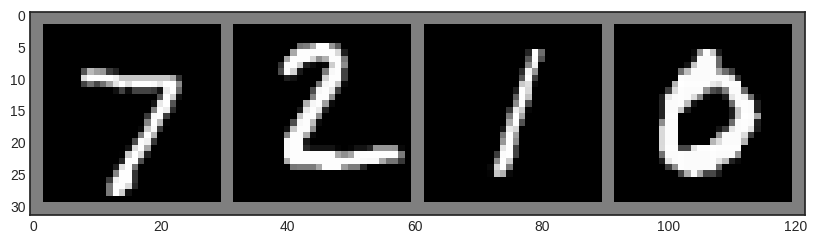

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([7, 2, 0, 0, 9, 7, 9, 9, 6, 9, 0, 6, 9, 0, 8, 3, 9, 7, 3, 9, 9, 6, 6, 0,
        9, 0, 7, 9, 0, 8, 3, 3, 3, 6, 7, 2, 7, 0, 2, 8, 0, 7, 9, 2, 3, 6, 3, 2,
        9, 9, 6, 3, 0, 6, 2, 0, 8, 9, 9, 7, 7, 8, 8, 3, 7, 9, 0, 0, 3, 0, 7, 0,
        2, 7, 8, 7, 3, 7, 9, 7, 9, 6, 2, 7, 8, 9, 7, 3, 6, 0, 3, 6, 8, 3, 8, 0,
        9, 7, 6, 9, 6, 0, 9, 9, 9, 9, 2, 8, 9, 9, 8, 7, 3, 9, 7, 6, 9, 0, 9, 9,
        8, 8, 7, 6, 7, 8, 0, 9])


In [ ]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range(4)))

7	2	0	0	


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for daa in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0) # 값
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

68.75


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

<ipython-input-2-254f20b072c8>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


- 현재 GPU 설정

In [ ]:
torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

- 데이터 로드


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)
testset = torchvision.datasets.MNIST(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


- 모델 생성

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))

    return x

  def num_flat_features(self, x):
    size = x.size()[1:] # 배치 사이즈만 빼고
    num_features = 1
    for s in size:
      num_features *= s

    return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
net = Net().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):

  running_loss = 0.0
  for i , data in enumerate(train_loader, 0):
    # 다른 점이라곤 아래 데이터를 cuda로 넘기는 것 뿐
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print('Epoch: {}, Iter: {}, Loss:{}'.format(epoch+1, i+1, running_loss/100))
      running_loss = 0.0

Epoch: 1, Iter: 100, Loss:2.300327248573303
Epoch: 1, Iter: 200, Loss:2.294096553325653
Epoch: 1, Iter: 300, Loss:2.2880009531974794
Epoch: 1, Iter: 400, Loss:2.279117696285248
Epoch: 2, Iter: 100, Loss:2.252083659172058
Epoch: 2, Iter: 200, Loss:2.2219919419288634
Epoch: 2, Iter: 300, Loss:2.1594040274620054
Epoch: 2, Iter: 400, Loss:2.013143866062164


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs ,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

51.15
